In [ ]:
pip install keras_metrics

In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras_metrics as km
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir ="/content/gdrive/My Drive/data/testreal"

img_height , img_width = 64, 64
seq_len = 16

In [ ]:
classes = [ 'climb', 'eat', 'fall', 'fall_down', 'grab', 'mouth','sit','walk']

In [ ]:
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame {}".format(video_path))
            break
 
            
    return frames_list

In [ ]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        print(files_list)
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [ ]:
X, Y = create_data(data_dir)
 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=36)

climb
['02.mp4', '05.mp4', '18.mp4', '10.mp4', '16.mp4', '08.mp4', '19.mp4', '01.mp4', '11.mp4', '04.mp4', '03.mp4', '14.mp4', '07.mp4', '09.mp4', '17.mp4', '13.mp4', '15.mp4', '06.mp4', '12.mp4', '100.mp4', '102.mp4', '104.mp4', '101.mp4', '103.mp4', '106.mp4', '108.mp4', '114.mp4', '113.mp4', '115.mp4', '110.mp4', '107.mp4', '118.mp4', '116.mp4', '111.mp4', '109.mp4', '112.mp4', '117.mp4', '105.mp4', '119.mp4', '122.mp4', '123.mp4', '21.mp4', '121.mp4', '125.mp4', '120.mp4', '20.mp4', '124.mp4', '25.mp4', '24.mp4', '31.mp4', '33.mp4', '23.mp4', '26.mp4', '30.mp4', '34.mp4', '22.mp4', '27.mp4', '29.mp4', '35.mp4', '36.mp4', '32.mp4', '28.mp4', '48.mp4', '38.mp4', '42.mp4', '39.mp4', '37.mp4', '44.mp4', '45.mp4', '40.mp4', '50.mp4', '47.mp4', '49.mp4', '46.mp4', '41.mp4', '43.mp4', '60.mp4', '53.mp4', '63.mp4', '62.mp4', '52.mp4', '59.mp4', '58.mp4', '56.mp4', '51.mp4', '55.mp4', '61.mp4', '57.mp4', '54.mp4', '66.mp4', '80.mp4', '81.mp4', '68.mp4', '75.mp4', '74.mp4', '76.mp4', '79.mp4

In [ ]:
model = Sequential()

model.add(ConvLSTM2D(filters = 128, kernel_size = (3, 3),strides = (2,2), return_sequences = True, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3),strides = (2,2), return_sequences = True, data_format = "channels_last"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),strides = (2,2), return_sequences = False, data_format = "channels_last"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation = "softmax"))
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 16, 31, 31, 128)   604160    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 31, 31, 128)   512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 31, 31, 128)   0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 16, 15, 15, 64)    442624    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 15, 15, 64)    256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 15, 15, 64)    0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 7, 7, 32)         

In [ ]:
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
 
history = model.fit(x = X_train, y = y_train, epochs=15, batch_size = 16 , shuffle=True, validation_split=0.2, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
47/47 [==============================] - 923s 19s/step - loss: 3.3223 - accuracy: 0.1596 - val_loss: 2.3274 - val_accuracy: 0.1489
Epoch 2/15
47/47 [==============================] - 909s 19s/step - loss: 2.4873 - accuracy: 0.3031 - val_loss: 1.9401 - val_accuracy: 0.2394
Epoch 3/15
47/47 [==============================] - 916s 20s/step - loss: 2.2136 - accuracy: 0.3383 - val_loss: 2.2173 - val_accuracy: 0.2128
Epoch 4/15
47/47 [==============================] - 913s 19s/step - loss: 2.0690 - accuracy: 0.3412 - val_loss: 2.8809 - val_accuracy: 0.1543
Epoch 5/15
47/47 [==============================] - 1523s 33s/step - loss: 2.1706 - accuracy: 0.3360 - val_loss: 2.2120 - val_accuracy: 0.2394
Epoch 6/15
47/47 [==============================] - 907s 19s/step - loss: 1.8617 - accuracy: 0.3712 - val_loss: 3.4251 - val_accuracy: 0.1915
Epoch 7/15
47/47 [==============================] - 916s 20s/step - loss: 1.6870 - accuracy: 0.4506 - val_loss: 3.0460 - val_accuracy: 0.0957
Epoch

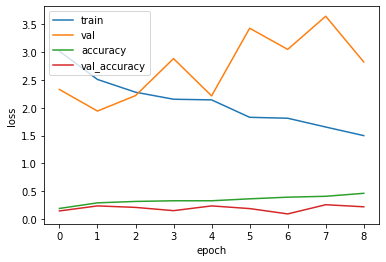

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val','accuracy','val_accuracy'])
plt.show()


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.12      0.65      0.21        17
           2       0.62      0.44      0.52        18
           3       0.25      0.50      0.34        42
           4       0.73      0.27      0.39        30
           5       0.64      0.23      0.34        39
           6       0.35      0.33      0.34        21
           7       0.50      0.02      0.05        42

    accuracy                           0.28       234
   macro avg       0.40      0.31      0.27       234
weighted avg       0.42      0.28      0.26       234



In [ ]:
from sklearn.metrics import accuracy_score

print('accuracy score : {}'.format(accuracy_score(y_pred, y_test)))

accuracy score : 0.2777777777777778
